# ECG Heartbeat Classification

* [Paper](https://arxiv.org/pdf/1805.00794.pdf)

Signification des labels :

| Category(data)        |  Category(Paper)     | Annotations  |
| ------------- |:-------------:| -----:|
|0|N| <ul><li>Normal</li><li>Left/Right bundle branch block</li><li>Arial escape</li><li>Nodal escape</li></ul>  |
|1|S| <ul><li>Atrial premature</li><li>Aberrant atrial premature</li><li>Nodal premature</li><li>Supra-ventricular premature</li></ul> |
|2|V| <ul><li>Premature ventricular contraction</li><li>Ventricular escape</li></ul> |
|3|F| <ul><li>Fusion of ventricular and normal</li></ul> |
|4|Q| <ul><li>Paced</li><li>Fusion of paced and normal</li><li>Unclassifiable</li></ul> |



# Librairies

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sb
import scipy as sc
sb.set_style("whitegrid")
import matplotlib.pyplot as plt


CMAP = plt.get_cmap("Set1")
COLOR = [CMAP(k) for k in range(5)]
NAME_DIC = {k:v for k,v in zip([0,1,2,3,4],['N','S','V','F','Q'])}

# Lecture des données

*In all of our experiments, we have used ECG lead II re-sampled to the sampling frequency of 125Hz as the input.*

Sampling : 125HZ, ie, a value every 0.008 seconds. One signal has 187 values over 1.488s 

In [2]:
# Nom des colonnes
Colnames = [str(k) for k in range(187)] + ["label"]

In [3]:
# Train
mitbih_train = pd.read_csv("mitbih_train.csv.zip", header=None, names=Colnames)
N_train = mitbih_train.shape[0]
print(mitbih_train.shape)
mitbih_train.head(5)

(87554, 188)


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Test
mitbih_test = pd.read_csv("mitbih_test.csv", header=None, names = Colnames)
N_test = mitbih_test.shape[0]
print(mitbih_test.shape)
mitbih_test.head(5)

(6774, 188)


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,label
0,1.000000,0.758982,0.473054,0.193114,0.142216,0.176647,0.161677,0.142216,0.121257,0.107784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.746556,0.088154,0.035813,0.212121,0.253444,0.269972,0.283747,0.275482,0.272727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.972840,0.728395,0.000000,0.037037,0.162963,0.143210,0.123457,0.140741,0.133333,0.096296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.000000,0.694444,0.238095,0.321429,0.337302,0.337302,0.301587,0.325397,0.325397,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.939815,0.791667,0.199074,0.000000,0.055556,0.101852,0.106481,0.143519,0.222222,0.189815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
import collections
collections.Counter(mitbih_test.label)

Counter({0.0: 3000, 1.0: 556, 2.0: 1448, 3.0: 162, 4.0: 1608})

## Illustration 

### Exemple

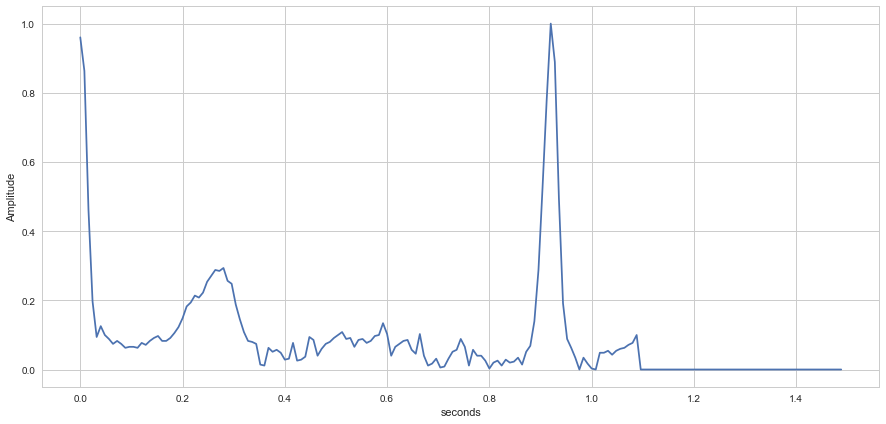

In [6]:
xsec = np.arange(187)*0.008

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
ax.plot(xsec,mitbih_train.values[1,:-1])
ax.set_xlabel("seconds")
ax.set_ylabel("Amplitude")
plt.show()

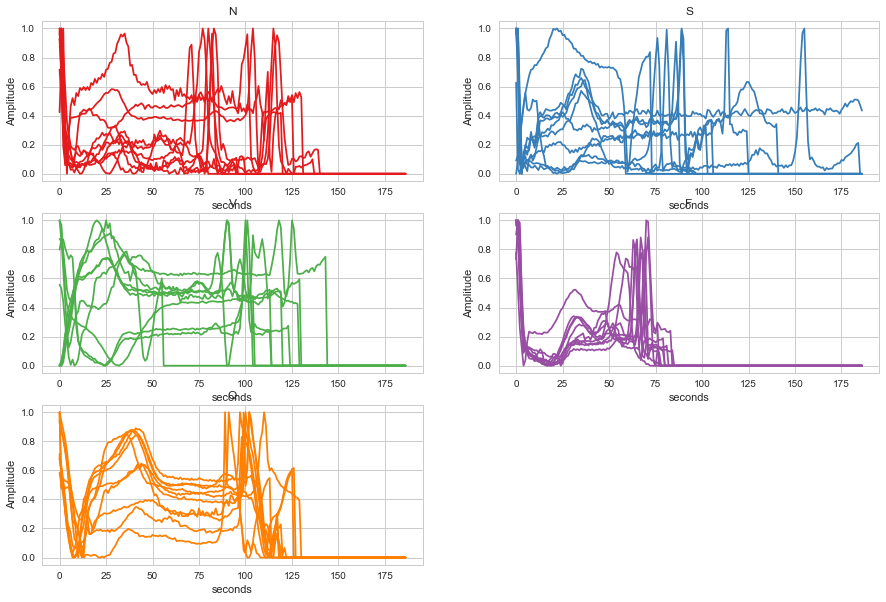

In [7]:
fig = plt.figure(figsize=(15,10))
for i,(k,v) in enumerate(mitbih_train.groupby("label")):
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(v.values[:10,:-1].T, color=COLOR[int(k)])
    ax.set_title(NAME_DIC[k])
    ax.set_xlabel("seconds")
    ax.set_ylabel("Amplitude")
plt.show()

# Répartition des catégories

## Test

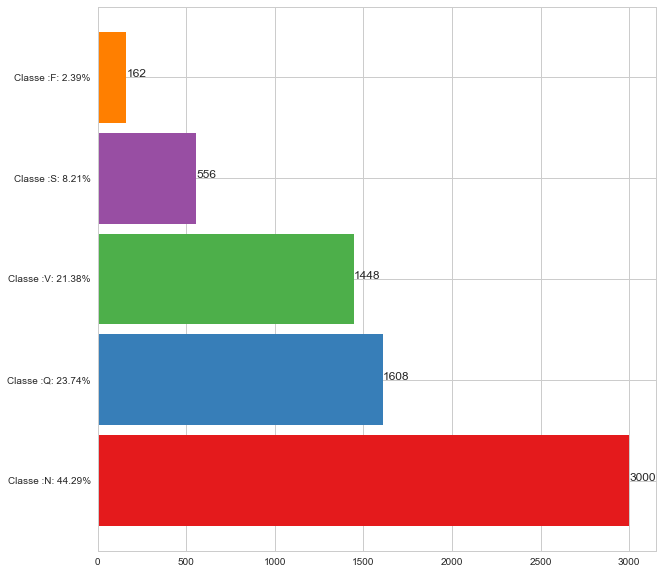

In [8]:
data_count = mitbih_test.label.astype(int).value_counts()
#Rename index to add percentage
new_index = ["Classe :" + NAME_DIC[k]+ ": %.2f%%" %(v*100/N_test) for k,v in data_count.iteritems()]

fig=plt.figure(figsize= (10,10))
ax = fig.add_subplot(1,1,1)
ax.barh(range(5), data_count.values, 0.9, color = COLOR, tick_label = new_index)
for k in range(5):
    ax.text(data_count.values[k], k, str(data_count.values[k]))
plt.show()


## Train

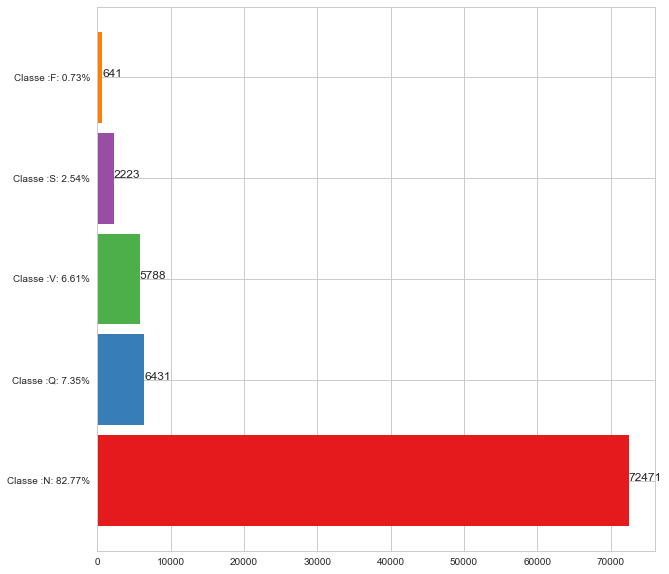

In [9]:
data_count = mitbih_train.label.astype(int).value_counts()
#Rename index to add percentage
new_index = ["Classe :" + NAME_DIC[k]+ ": %.2f%%" %(v*100/N_train) for k,v in data_count.iteritems()]

fig=plt.figure(figsize= (10,10))
ax = fig.add_subplot(1,1,1)
ax.barh(range(5), data_count.values, 0.9, color = COLOR, tick_label = new_index)
for k in range(5):
    ax.text(data_count.values[k], k, str(data_count.values[k]))

plt.show()

## Augmentation des données

Les données sont fortement déséquilibrées. Particulièrement la classe "F" qui ne possèdent que 641 éléments dans l'apprentissage. Pour corriger cela on peut pocéder à 
    * de l'oversampling, en dupliquant certaines série
    * de l'augmentation de données, en créant de nouveaux signaux par déformation des signaux existant

### Amplify

Amplifie le signal suivant la formule suivante : 

new_x =  $-\alpha\cdot x^2 + -\alpha\cdot x^2 + x$ avec $-0.5<\alpha<0.5$

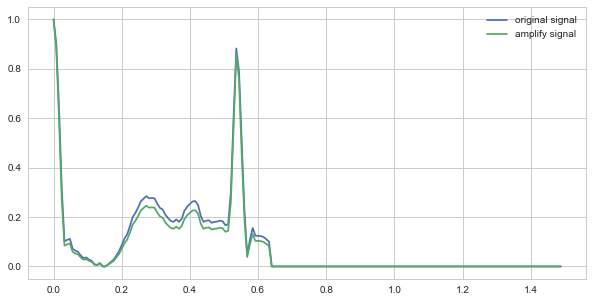

In [10]:
def amplify(x):
    alpha = (np.random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

x_toy = mitbih_train.groupby("label").get_group(3).values[0,:-1]
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(xsec,x_toy, label = 'original signal')
ax.plot(xsec,amplify(x_toy), label = 'amplify signal')
plt.legend()


### Stretch

Etire ou "compresse" le signal. Cette étape est effectué grace à la fonction *resample* du package *scipy.signal* qui permet de ré-echantilloner un signal grace à une transformé de Fourier.

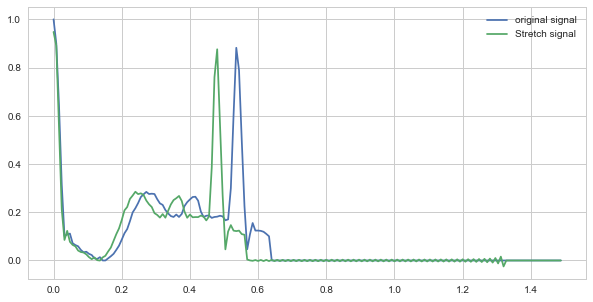

In [11]:
from scipy.signal import resample
def stretch(x):
    l = int(187 * (1 + (np.random.random()-0.5)/3))
    y = sc.signal.resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(xsec,x_toy, label = 'original signal')
ax.plot(xsec,stretch(x_toy), label = 'Stretch signal')
plt.legend()

En utilisant une de ces deux fonctions, ou en combinant les deux, il est alors possible de créer de nouveau signaux.

# Création de Features

In [12]:
X_train = mitbih_train.values[:,:-1]
Y_train = mitbih_train.values[:,-1]

X_test = mitbih_test.values[:,:-1]
Y_test = mitbih_test.values[:,-1]

## General Features

### Dyadique

Cette section permet de créer de nouvelles variables ou "features" à partir de statistiques élémentaires : La *moyenne*, *la médiane* etc...
Afin de rendre ces features plus pertinentes, une technique consiste à créer ces features sur différentes divisions du signal. 

On va donc calculer pour chaque statistique (par exemple la moyenne) sa valeur sur l'ensemble de la courbe. On va ensuite découper le signal en deux, et calculer la moyenne sur la première et la seconde partie. On répète cette opération sur un découpage du signal en 4 divisions, puis en 8 et ainsi de suite pour différentes puissances de 2. 

Trois fonctions sont définies ci-dessous afin de créer ces nouvelles features.

* **basic_features** : Calcul des statistiques simples pour chacun des signaux contenus dans la matrice *X*.
* **basic_features_per_block** : Calcul des statistiques simples sur chaque division d'un partitionnement spécifique des signaux contenus dans la matrice X. 
Ce partitionnement peut être définies à partir d' **un des deux** paramètres :
    * n_block : Nombre de division.
    * n_step : Taille d'une division.
* **basic_features_dyadique** : Calcul des statistiques simples sur différents partitionnements des signaux contenus dans la matrice X. Les partitionnement générés sont tous les partitionnement en 2^i divisions du signal, pour i allant de 0 à *power* ou *power* est un argument de la fonction. 
    



In [13]:
def basic_features(X):
    basic_features_list = []
    basic_features_list.append(np.mean(X, axis=1))
    basic_features_list.append(np.median(X, axis=1))
    basic_features_list.append(np.max(X, axis=1))
    basic_features_list.append(np.argmax(X, axis=1))
    basic_features_list.append(np.std(X ,axis=1))
    basic_features_list.append(np.apply_along_axis(sc.stats.entropy, 1, X))
    basic_features_list.append(np.apply_along_axis(sc.stats.skew, 1, X))
    basic_features_list.append(np.apply_along_axis(sc.stats.kurtosis, 1, X))

    X_bf = np.vstack(basic_features_list).T
    return X_bf

#Exemple sur un signal
X_test_bf = basic_features(X_test[:1,:])
print("All signal : Mean = %.2f, Median = %.2f, Max = %.2f, Argmax = %.2f, std = %.2f, entropy = %.2f, skew = %.2f, kurtosis = %.2f" %tuple(X_test_bf[0]))

All signal : Mean = 0.13, Median = 0.05, Max = 1.00, Argmax = 0.00, std = 0.18, entropy = 4.35, skew = 2.14, kurtosis = 6.47


In [14]:
def basic_features_per_block(X, n_block=None, n_step=None):
    N = X.shape[1]
    if not(n_block is None) and not(n_step is None):
        raise ValueError("You can't specify both n_block AND n_step")
    elif (n_block is None) and (n_step is None):
        raise ValueError("You have to specify  either n_block OR n_step")
    elif n_block is None:
        blocks = np.hstack((np.arange(0,N,n_step),N))
    else:
        blocks = np.linspace(0,N,n_block+1,dtype=int)
    basic_features_per_block = []
    n_blocks = len(blocks)-1
    for s_block, e_block in [blocks[k:k+2] for k in range(n_blocks)] :
        basic_features_per_block.append(basic_features(X[:,s_block:e_block]))
        
    return np.hstack(basic_features_per_block), blocks

#Exemple sur un signal
X_test_bfbloc = basic_features_per_block(X_test[:1,:], n_block=2)
print("First block  : Mean = %.2f, Median = %.2f, Max = %.2f, Argmax = %.2f, std = %.2f, entropy = %.2f, skew = %.2f, kurtosis = %.2f" %tuple(X_test_bfbloc[0][0][:8]))
print("Second block : Mean = %.2f, Median = %.2f, Max = %.2f, Argmax = %.2f, std = %.2f, entropy = %.2f, skew = %.2f, kurtosis = %.2f" %tuple(X_test_bfbloc[0][0][8:]))

First block  : Mean = 0.25, Median = 0.24, Max = 1.00, Argmax = 0.00, std = 0.17, entropy = 4.34, skew = 2.26, kurtosis = 6.53
Second block : Mean = 0.00, Median = 0.00, Max = 0.10, Argmax = 1.00, std = 0.01, entropy = 0.69, skew = 6.73, kurtosis = 43.66


In [15]:
#LONG!
def basic_features_dyadique(X, power):
    N = X.shape[1]
    basic_features_dyatique = []
    for p in range(power+1):
        basic_features_dyatique.append(basic_features_per_block(X, n_block=2**p)[0])
    [print(k.shape) for k in basic_features_dyatique ]
    return np.hstack(basic_features_dyatique)

#Exemple sur un signal
X_test_dy = basic_features_dyadique(X_test[:1,:], power=1)
print("All Signal  : Mean = %.2f, Median = %.2f, Max = %.2f, Argmax = %.2f, std = %.2f, entropy = %.2f, skew = %.2f, kurtosis = %.2f" %tuple(X_test_dy[0][:8]))
print("First block  : Mean = %.2f, Median = %.2f, Max = %.2f, Argmax = %.2f, std = %.2f, entropy = %.2f, skew = %.2f, kurtosis = %.2f" %tuple(X_test_dy[0][8:16]))
print("Second block : Mean = %.2f, Median = %.2f, Max = %.2f, Argmax = %.2f, std = %.2f, entropy = %.2f, skew = %.2f, kurtosis = %.2f" %tuple(X_test_dy[0][16:]))

(1, 8)
(1, 16)
All Signal  : Mean = 0.13, Median = 0.05, Max = 1.00, Argmax = 0.00, std = 0.18, entropy = 4.35, skew = 2.14, kurtosis = 6.47
First block  : Mean = 0.25, Median = 0.24, Max = 1.00, Argmax = 0.00, std = 0.17, entropy = 4.34, skew = 2.26, kurtosis = 6.53
Second block : Mean = 0.00, Median = 0.00, Max = 0.10, Argmax = 1.00, std = 0.01, entropy = 0.69, skew = 6.73, kurtosis = 43.66


### ACP

In [16]:
def plot_variance_acp(fig, acp, X_acp, whis=1.5): 
    ax = fig.add_subplot(1,2,1)
    ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
    ax.set_xticks(range(10))
    ax.set_ylabel("Variance")
    ax.set_title("", fontsize=35)
    ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)
    
    ax = fig.add_subplot(1,2,2)
    box=ax.boxplot(X_acp[:,0:10], whis=whis)
    ax.set_title("Distribution des premieres composantes", fontsize=20)
    
def plot_pca(ax, X, acp, nbc, nbc2, colors, markersizes):
    ax.scatter(X[:,nbc-1],X[:,nbc2-1],marker=".", color= colors, s=markersizes)
    ax.set_xlabel("PC%d : %.2f %%" %(nbc,acp.explained_variance_ratio_[nbc-1]*100), fontsize=15)
    ax.set_ylabel("PC%d : %.2f %%" %(nbc2,acp.explained_variance_ratio_[nbc2-1]*100), fontsize=15)


In [17]:
import sklearn.decomposition as sdec 
pca = sdec.PCA()
X_r = pca.fit_transform(mitbih_train.values[:,:-1])

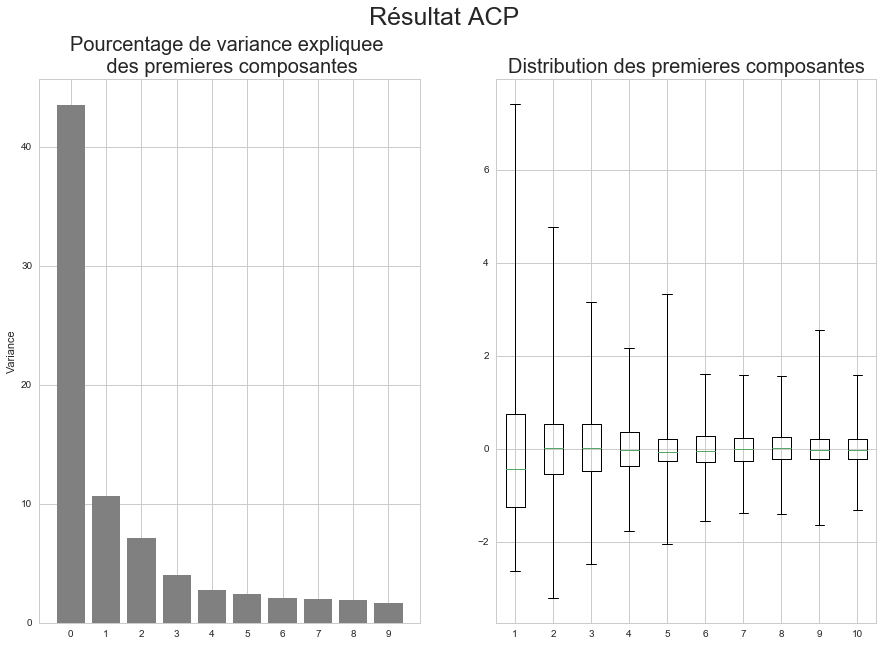

In [18]:
fig = plt.figure(figsize=(15,10))
plot_variance_acp(fig, pca, X_r, whis=100)
fig.suptitle("Résultat ACP", fontsize=25)

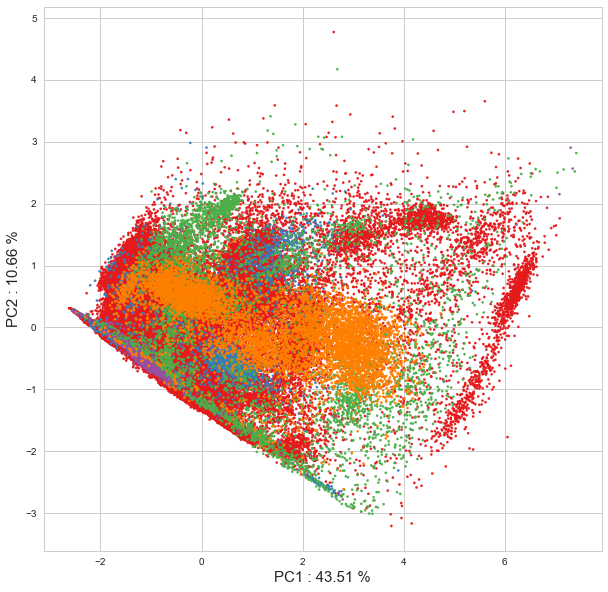

In [19]:
colors=[COLOR[int(y)] for y in mitbih_train.values[:,-1]]
markersizes = [20 for _ in range(N_train)]
fig = plt.figure(figsize=(10,10), )
ax = fig.add_subplot(1,1,1)
plot_pca(ax,X_r, pca, 1, 2, colors, markersizes)

### FDA

In [20]:
import sklearn.discriminant_analysis as sda
method = sda.LinearDiscriminantAnalysis() 
lda=method.fit(mitbih_train.values[:,:-1],mitbih_train.values[:,-1])
X_r2=lda.transform(mitbih_train.values[:,:-1])

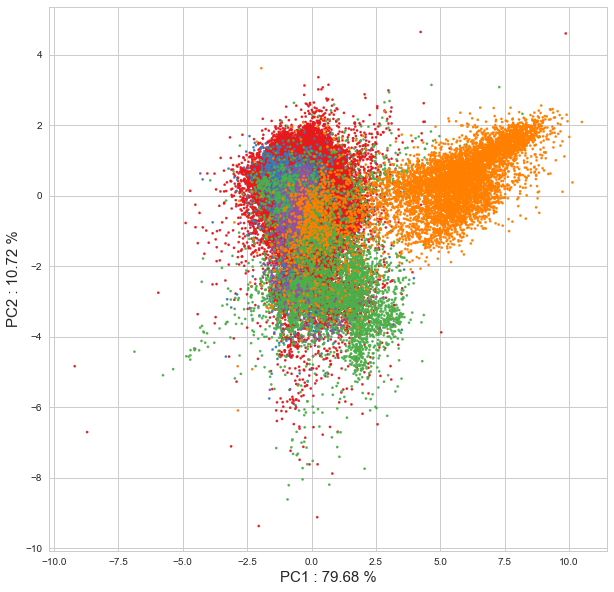

In [21]:
colors=[COLOR[int(y)] for y in mitbih_train.values[:,-1]]
markersizes = [20 for _ in range(N_train)]
fig = plt.figure(figsize=(10,10), )
ax = fig.add_subplot(1,1,1)
plot_pca(ax,X_r2, lda, 1, 2, colors, markersizes)

### Ondelette

In [22]:
def coef_pyramid_plot(ax, coefs, first=0, scale='uniform'):
    n_levels = len(coefs)
    n = 2**(n_levels - 1) # assumes periodic

    if scale == 'uniform':
        biggest = [np.max(np.abs(np.hstack(coefs)))] * n_levels
    else:
        # multiply by 2 so the highest bars only take up .5
        biggest = [np.max(np.abs(i))*2 for i in coefs]

    for i in range(first,n_levels):
        x = np.linspace(2**(n_levels - 2 - i), n - 2**(n_levels - 2 - i), 2**i)
        ymin = n_levels - i - 1 + first
        yheight = coefs[i]/biggest[i]
        ymax = yheight + ymin
        ax.vlines(x, ymin, ymax, linewidth=1.1)

    ax.set_xlim(0,n)
    ax.set_ylim(first - 1, n_levels)
    ax.yaxis.set_ticks(np.arange(n_levels-1,first-1,-1))
    ax.yaxis.set_ticklabels(np.arange(first,n_levels))
    ax.tick_params(top=False, right=False, direction='out', pad=6)
    ax.set_ylabel("Levels", fontsize=14)
    ax.grid(True, alpha=.85, color='white', axis='y', linestyle='-')
    ax.set_title('Wavelet Detail Coefficients', fontsize=16,
            position=(.5,1.05))

In [23]:
import pywt
from pywt import wavedec

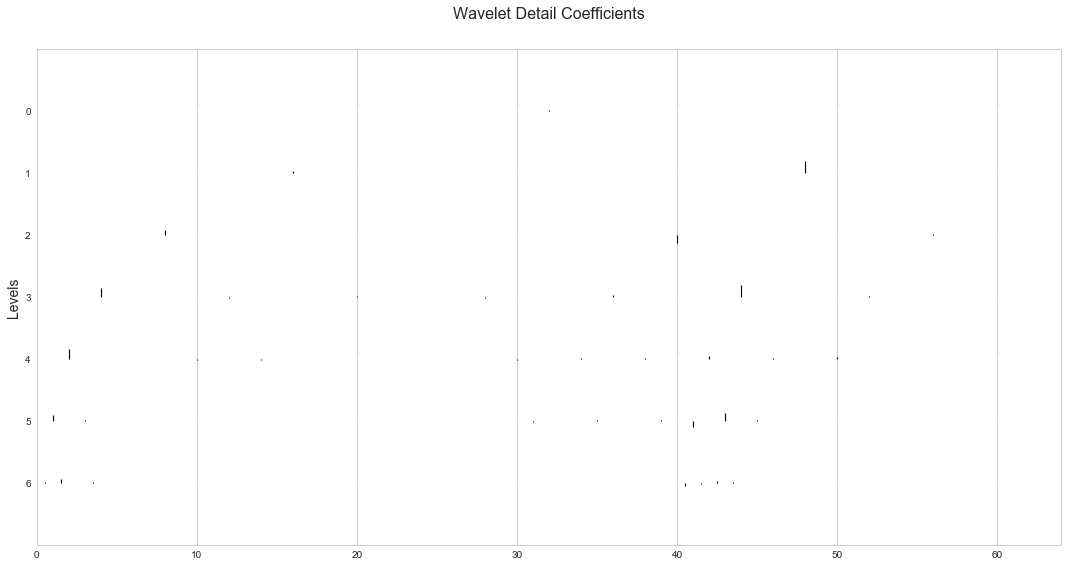

In [24]:
fig = plt.figure(figsize=(15,8))
ax=fig.add_subplot(1,1,1)
coef = pywt.wavedec(mitbih_train.values[:,:-1], 'db1')
coef_pyramid_plot(ax, coef[1:]) ;
fig.tight_layout()

In [25]:
X_train_db = np.concatenate(pywt.wavedec(mitbih_train.values[:,:-1], 'db1'), axis=1)
## ACP 
pca = sdec.PCA()
X_train_db_pca = pca.fit_transform(X_train_db)

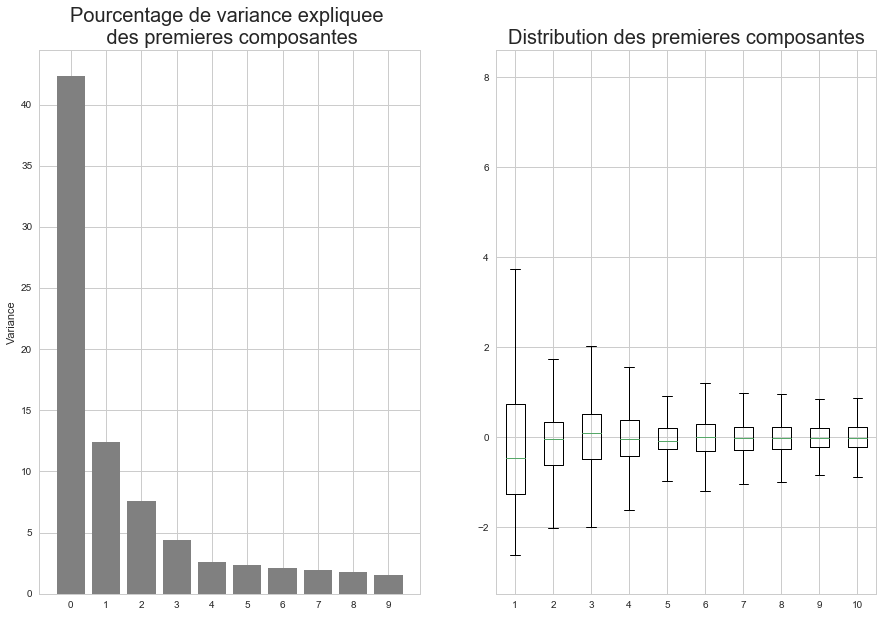

In [26]:
fig = plt.figure(figsize=(15,10))
plot_variance_acp(fig, pca, X_train_db_pca)

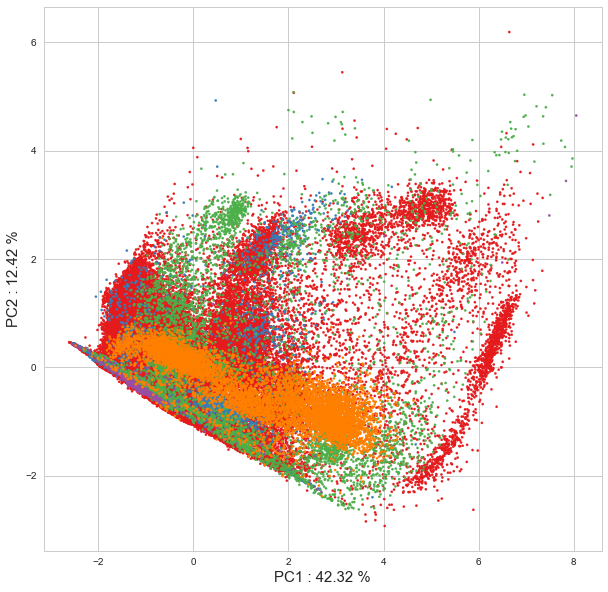

In [27]:
colors=[COLOR[int(y)] for y in mitbih_train.values[:,-1]]
markersizes = [20 for _ in range(N_train)]
fig = plt.figure(figsize=(10,10), )
ax = fig.add_subplot(1,1,1)
plot_pca(ax,X_train_db_pca, pca, 1, 2, colors, markersizes)